## Problem

Let  
* $G = (V,E)$ be an undirected graph, with node set $V = \{1,\ldots, n\}$ and edge set $E \subseteq \{ (i,j) | i,j\in V, i \neq j \}$
* $ w_v: V \to \mathbb{R}_{\geq}$ be the non-negative weights function to the vertices of $G$
* $ w_e: E \to \mathbb{R}_{\geq}$ be the non-negative weights function to the edges of $G$ (pending)
* $k\geq 2$ an integer denoting the number of connected components to partition $G$ into

Find
* $\mathcal{F}=\{(V_i, E_i)\}_{i\in[k]}$ a connected $k$-partition of $G$  
where $V_i\cap V_j=\emptyset$ for $i \neq j$, $\bigcup_{i=1}^k V_i=V$, and $V_i \neq \emptyset$, for all $ i, j \in [k]$. $\bigcup_{i=1}^k E_i \subseteq V$ for all $ i \in [k]$. $[k]$ denotes the set $\{1,\ldots,k\}$

Goal
* minimize $\max_{i \in [k]} \{w(G_i)\}$  
$ w(G) = \sum_{v \in V} w_v(v)$ for the general vertex-weighted $BCP_k$ problem  
$ w(G) = \sum_{e \in E} w_e(e)(\sum_{v \in V_e} w_v(v))^2$, where $V_e$ denotes the successor vertices to $e$

By this definition, $G$ can be a cyclic graph with several vertices zero-weighted. $\mathcal{F}$ is generated from edge cut. With certain mathermatical modeling, especially the following one, $\mathcal{F}$ results in a set of spanning trees. Thus, it can be termed as a spanning forest problem. However, it is not the minimum spanning forest because the optimization does not target the average depth.

## Formulation

Variable
* $f_a$ a non-negative continuous variable representing the flow over the arc $a:u\rightarrow v$
* $y_a$ a binary variable associated with the arc, taking the value of one if $f_a > 0$, and zero otherwise

The model below is inspired by this paper: Partitioning a graph into balanced connected classes: Formulations, separation and experiments, Flávio K. Miyazawa, e.g. (2021). Notions for its construction:
* take source nodes $s \in S$ with $|S|=k$ either 1) as phantoms added to $G$ to create directed graph $G'=(V \cup S, A)$ where $A = \{(u,v)|u,v \in V, u\neq v\} \cup \{(u,v)|u\in V, v\in S\}$, or 2) pre-defined in $G$ to create directed graph $G'=(V \backslash S, A)$ where $A = \{(u,v)|u,v \in V, u\neq v\} \backslash \{(u,v)|u \in V\backslash S, v\in S\}$. Either way we have source set $S$ and terminal set $T$ containing the rest nodes. Each edge of $G$ (except for those incident to $s\in S$) thus has two associated antiparallel arcs $u\rightarrow v$ and $v\rightarrow u$, $u, v\in T$
* sets $\delta^−(v)$ and $\delta^+(v)$ contain ingoing and outgoing arcs to the node $v$, respectively
* $y(A)=\sum_{a \in A} y_a$ and $f(A)=\sum_{a\in A} f_a$ as a shorthand for summation of variables in a set

\begin{align}
&\max f(\delta^+(s_1))
\\
\text{s.t.} & 
\\
&f(\delta^+(s_i)) \leq f(\delta^+(S_{i+1})), &&\forall i \in [k-1],
\\
&f(\delta^-(v)) - f(\delta^+(v))=w_v(v), &&\forall v\in T,
\\
&f_a \leq w(G)y_a, &&\forall a \in A,
\\
&y(\delta^+(s_i)) \leq 1, &&\forall v \in [k],
\\
&y(\delta^-(v)) \leq 1, &&\forall v \in T,
\\
&y_a \in \{0, 1\}, &&\forall a \in A,
\\
&f_a \in \mathbb{R}_\geq, &&\forall a \in A.
\end{align}

## Implementation

Gurobi is the solver for this Mixed Integer Programming

In [1]:
import re
import json

import gurobipy as gp
from gurobipy import GRB

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
with open('graph.json', 'r') as f:
    data = json.load(f)

# Unzip nodes and edges from JSON
weights = [node['weight'] for node in data['nodes']]
sizes = [node['weight']/20 for node in data['nodes']]
edges = [(edge['source'], edge['target']) for edge in data['links']]
# be careful whether these edges are bi-directional or not

G = nx.Graph()
# initiate nodes before adding edges to prevent disorder
G.add_nodes_from([i for i in range(len(weights))])
G.add_edges_from(edges)
V = G.nodes()
E = G.edges()
print('(V,E) =', (len(V), len(E)))

(V,E) = (113, 116)


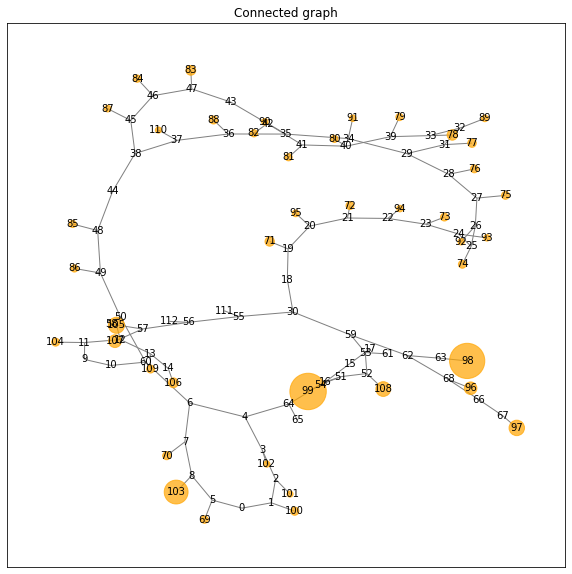

In [3]:
# Display graph
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, seed=59)
nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=sizes, alpha=0.7)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.title('Connected graph' if nx.is_connected(G) else 'Warning: unconnected graph')
plt.draw()

In [ ]:
# add new sources by number of k, each forming a distributed region
# add edges connecting each source in S to each vertex in V

# append phantom source nodes to G
# k = 2
# S = [len(V) + i for i in range(k)]
# A_source = [(i,j) for i in S for j in V]             # from source to rest vertex
# E_reversed = [(j,i) for (i,j) in E]
# A = list(E) + E_reversed + A_source
# T = list(V)

# segregate nodes from G as sources
k = 2
S = [111, 112]
A_source = [(111, 55), (112, 56)]
E_truncated = []
for edge in E:
    if edge[0] == 111 or edge[1] == 111 or edge[0] == 112 or edge[1] == 112:
        pass
    else:
        E_truncated.append(edge)
E_reversed = [(j,i) for (i,j) in E_truncated]
A = E_truncated + E_reversed + A_source
T = [x for x in list(V) if x not in S]

Gx = nx.DiGraph()
Gx.add_nodes_from([x for x in range(len(S) + len(T))])
Gx.add_edges_from(A)
nx.set_edge_attributes(Gx, 1, 'weight')
nx.set_node_attributes(Gx, 0, 'weight')
for i, weight in enumerate(weights):
    Gx.nodes[i]['weight'] = weight
W = sum(weights)

### Create model

In [ ]:
if 'mo' in globals():
    mo.dispose()
    gp.disposeDefaultEnv()
    del mo

In [ ]:
mo = gp.Model()
y, f = gp.tupledict(), gp.tupledict()    # Dictionaries will contain variables

# Binary indicator of flow direction (permitted or not)
y = mo.addVars(A, vtype=GRB.BINARY, name = 'y')
# flow on an arc induced by A
f = mo.addVars(A, vtype=GRB.CONTINUOUS, name = 'f')

mo.update()

In [ ]:
# *** Constraints ***
mo.setObjective(gp.quicksum(f[S[0], v] for v in Gx.successors(S[0])), sense=GRB.MINIMIZE)
# The outflow of s_i follows an ascending order so the optimum function may work
mo.addConstrs((gp.quicksum(f[i,j] for j in Gx.successors(i)) >= gp.quicksum(f[i+1,j] for j in Gx.successors(i+1)) 
               for i in S[0:-1]), name='R1')
# the vertex weight equals to the flow it consumes from inflow
mo.addConstrs((gp.quicksum(f[i,v] for i in Gx.predecessors(v)) - gp.quicksum(f[v,j] for j in Gx.successors(v)) \
               == Gx.nodes[v]['weight'] for v in T), name='R2')
# flow direction restriction
mo.addConstrs((f[i,j] <= W * y[i,j] for (i,j) in A), name='R3')
# all outflows from each source node can only be 0 or 1
mo.addConstrs((gp.quicksum(y[i,j] for j in Gx.successors(i)) <= 1 for i in S), name='R4')
# if you need to restirct the outflow of all nodes to be only one path, change it to this:
# mo.addConstrs((quicksum(y[i,j] for j in Gx.neighbors(i, mode='out')) <= 1 for i in (S + T)), name='R4')

# all inflows from each vertex node can only be 0 or 1
mo.addConstrs((gp.quicksum(y[i,j] for i in Gx.predecessors(j)) <= 1 for j in T), name='R5')

In [17]:
mo.Params.TimeLimit = 15*60
mo.optimize()
if mo.Status == GRB.INFEASIBLE:
    mo.computeIIS()
    mo.write("model.lp")

Set parameter TimeLimit to value 900
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 455 rows, 460 columns and 1152 nonzeros
Model fingerprint: 0x4808dbe0
Variable types: 230 continuous, 230 integer (230 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
Presolve removed 295 rows and 301 columns
Presolve time: 0.01s
Presolved: 160 rows, 159 columns, 432 nonzeros
Variable types: 98 continuous, 61 integer (61 binary)

Root relaxation: objective 6.171946e+04, 94 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0

In [ ]:
for v in mo.getVars():
    print(f"{v.VarName} = {v.X}")

In [11]:
import copy

connections = []

for v in mo.getVars():
    if v.X > 0.0:
        result = re.match(r'y\[(\d+),(\d+)\]', v.VarName)
        if result is None:
            break
        node_start, node_end = result.groups()
        connections.append((int(node_start), int(node_end)))
# here I remove all arcs spreading from source nodes
for i in reversed(range(len(connections))):
    if connections[i][0] in S or connections[i][1] in S:
        connections.remove(connections[i])

# rebuild the graph that has connected vertices
clusters = []
_connections = copy.deepcopy(connections)
def isJoined(edge1, edge2):
    for i in range(2):
        if edge1[i] == edge2[i] and edge1[1-i] != edge2[1-i] or \
           edge1[i] == edge2[1-i] and edge1[1-i] != edge2[i]:
            return True
def flattenClusters(nested_edges):
    nested_nodes = []
    for edges in nested_edges:
        nodes = []
        for edge in edges:
            nodes.append(edge[0])
            nodes.append(edge[1])
        nested_nodes.append(list(set(nodes)))
    return nested_nodes

while len(_connections) > 0:
    flag = True
    while flag:
        flag = False
        for cluster in clusters:
            for edge in cluster:
                for i in reversed(range(len(_connections))):
                    if isJoined(_connections[i], edge):
                        cluster.append(_connections[i])
                        _connections.remove(_connections[i])
                        flag = True
                        break
    if len(_connections) > 0:
        clusters.append([_connections[-1]])
        _connections.remove(_connections[-1])

partition_node = flattenClusters(clusters)
partition_num = len(partition_node)
partition_edge = [[] for i in range(partition_num)]
removed_edge = []
for edge in list(E):
    edge_rev = (edge[1], edge[0])
    if edge in connections or edge_rev in connections:
        for i in range(partition_num):
            if edge[0] in partition_node[i] or edge[1] in partition_node[i]:
                partition_edge[i].append(edge)
    else:
        removed_edge.append(edge)

print("-nodes-", partition_node)
print("-edges-", partition_edge)
print("-del_edge-", removed_edge)
print("number of clusters is ", partition_num)


-nodes- [[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 53, 55, 59, 61, 62, 63, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 110], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 49, 50, 51, 52, 54, 56, 57, 58, 60, 64, 65, 69, 70, 86, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109], [17, 15]]
-edges- [[(18, 19), (18, 30), (19, 20), (19, 71), (20, 21), (20, 95), (21, 22), (21, 72), (22, 23), (22, 94), (23, 24), (23, 73), (24, 25), (24, 93), (25, 26), (25, 74), (26, 27), (26, 92), (27, 28), (27, 75), (28, 29), (28, 76), (29, 31), (29, 34), (30, 55), (30, 59), (31, 32), (31, 77), (32, 33), (32, 89), (33, 78), (34, 35), (34, 91), (35, 36), (35, 90), (36, 37), (36, 88), (37, 38), (37, 110), (38, 44), (38, 45), (39, 40), (39, 79), (40, 41), (40, 80), (41, 42), (41, 81), (42, 43), (42, 82), (43, 47), (44, 48), (45, 46), (45, 87),

In [12]:

size_scheme = []
for partition in partition_node:
    size_scheme.append([sizes[i] for i in partition])
print(size_scheme)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 89.1209145, 62.69559965, 62.335128350000005, 62.04938575, 62.18350769999999, 61.98747005, 72.70626250000001, 108.96776385000001, 52.27246720000001, 52.05346335, 52.2536702, 53.523082599999995, 95.05499695, 54.01475455, 51.0251412, 44.3509937, 64.53363315, 45.034707250000004, 44.3868663, 43.19319835, 42.53449955, 43.28402345, 43.43405025, 47.2727534, 159.04147135, 239.33232145000002, 1240.6466898, 39.0360003], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.472864, 65.7099752, 53.8783796, 1327.00281115, 68.3901941, 38.010386249999996, 40.11389955, 568.8212267, 64.40667545, 259.66807574999996, 96.92212620000001, 163.88833535, 218.2064978, 63.1292916], [0.0, 0.0]]


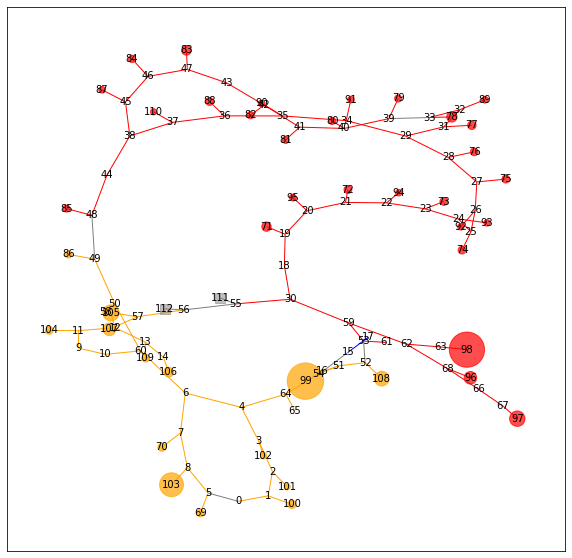

In [13]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, seed=59)
colors = ['red', 'orange', 'blue', 'green']

for i in range(partition_num):
    nx.draw_networkx_nodes(G, pos, nodelist=partition_node[i], node_color=colors[i], node_size=size_scheme[i], alpha=0.7)
# draw source nodes if they are inside G or the graph layout will change
nx.draw_networkx_nodes(G, pos, nodelist=S, node_color='grey', node_size=100, node_shape='s', alpha=0.5)

for i in range(partition_num):
    nx.draw_networkx_edges(G, pos, edgelist=partition_edge[i], edge_color=colors[i], arrows=None)
nx.draw_networkx_edges(G, pos, edgelist=removed_edge, edge_color='gray', arrows=None)

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.draw()

In [ ]:
Data = pd.DataFrame.from_dict(
    {'Instance':[(len(V),len(E),k)],
     'z_R':[mo.ObjBound],'Obj': mo.objval,'gap': mo.MIPgap,'nodes':int(mo.nodecount), 'time':mo.RunTime})
display(Data)

# patrol walks

k = 2
Gx = ig.Graph(directed = True)
Gx.add_vertices(10)
S = [8, 9]
V = [0, 1, 2, 3, 4, 5, 6, 7]
edge_list = [(0,1), (1,2), (0,2), (2,3), (3,4), (3,5), (4,5), (4,6), (5,7), (6,7)]
edge_list_rev = [(j,i) for (i,j) in edge_list]
source_edges = [(i,j) for i in S for j in V]
weights = [2, 1, 1, 3, 1, 4, 3, 2]
A = edge_list + edge_list_rev + source_edges
D = edge_list + edge_list_rev
Gx.add_edges(A)
for i, weight in enumerate(weights):
    Gx.vs[i]['weight'] = weight
W = 17